In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib.ticker import AutoMinorLocator

import utils

%matplotlib inline

plt.style.use('/mnt/home/tnguyen/default.mplstyle')

### Read data

In [41]:
data_root = "/mnt/ceph/users/tnguyen/florah/sc-sam/florah-tree/"
sim_table = utils.read_all_props(os.path.join(data_root, 'vsmdpl_sim/output'))
gen_table = utils.read_all_props(os.path.join(data_root, 'vsmdpl_gen/output'))
z = 5.89
sat_types = [0, 1, 2, 3]

select = (sim_table['mstar'] > 0) & np.isin(sim_table['sat_type'], sat_types)
sim_table = sim_table[select]
select = (gen_table['mstar'] > 0) & np.isin(gen_table['sat_type'], sat_types)
gen_table = gen_table[select]

In [42]:
mhalo_bins = np.arange(5.5, 12.5, 0.25)
mhalo_bins_ce = 0.5 * (mhalo_bins[1:] + mhalo_bins[:-1])
num_bins = len(mhalo_bins) - 1
q = [50, 16, 84]
min_count = 10

In [43]:
sim_table.columns

Index(['halo_index', 'birthhaloid', 'roothaloid_x', 'redshift_x', 'sat_type',
       'mhalo', 'm_strip', 'rhalo', 'mstar', 'mbulge', 'mstar_merge', 'v_disk',
       'sigma_bulge', 'r_disk', 'r_bulge', 'mcold', 'mHI', 'mH2', 'mHII',
       'Metal_star', 'Metal_cold', 'sfr', 'sfrave20myr', 'sfrave100myr',
       'sfrave1gyr', 'mass_outflow_rate', 'metal_outflow_rate', 'mBH',
       'maccdot', 'maccdot_radio_x', 'tmerge', 'tmajmerge', 'mu_merge',
       't_sat', 'r_fric', 'x_position', 'y_position', 'z_position', 'vx', 'vy',
       'vz', 'halo_id', 'roothaloid_y', 'orighaloid', 'redshift_y', 'm_vir',
       'c_nfw', 'spin', 'm_hot', 'mstar_diffuse', 'mass_ejected', 'mcooldot',
       'maccdot_pristine', 'maccdot_reaccrete', 'maccdot_metal_reaccrete',
       'maccdot_metal', 'mdot_eject', 'mdot_metal_eject', 'maccdot_radio_y',
       'Metal_hot', 'Metal_ejected', 'snap_num'],
      dtype='object')

In [44]:
sim_log_mbh = np.log10(sim_table['mBH'].to_numpy()) + 9
sim_log_mhalo = np.log10(sim_table['mhalo'].to_numpy()) + 9
gen_log_mbh = np.log10(gen_table['mBH'].to_numpy()) + 9
gen_log_mhalo = np.log10(gen_table['mhalo'].to_numpy()) + 9

sim_log_mbh_q = np.zeros((num_bins, len(q)))
gen_log_mbh_q = np.zeros((num_bins, len(q)))
for i in range(num_bins):
    select = (sim_log_mhalo > mhalo_bins[i]) & (sim_log_mhalo < mhalo_bins[i+1])
    if select.sum() < min_count:
        sim_log_mbh_q[i] = np.nan
    else:
        sim_log_mbh_q[i] = np.nanpercentile(sim_log_mbh[select], q)

    select = (gen_log_mhalo > mhalo_bins[i]) & (gen_log_mhalo < mhalo_bins[i+1])
    if select.sum() < min_count:
        gen_log_mbh_q[i] = np.nan
    else:
        gen_log_mbh_q[i] = np.nanpercentile(gen_log_mbh[select], q)

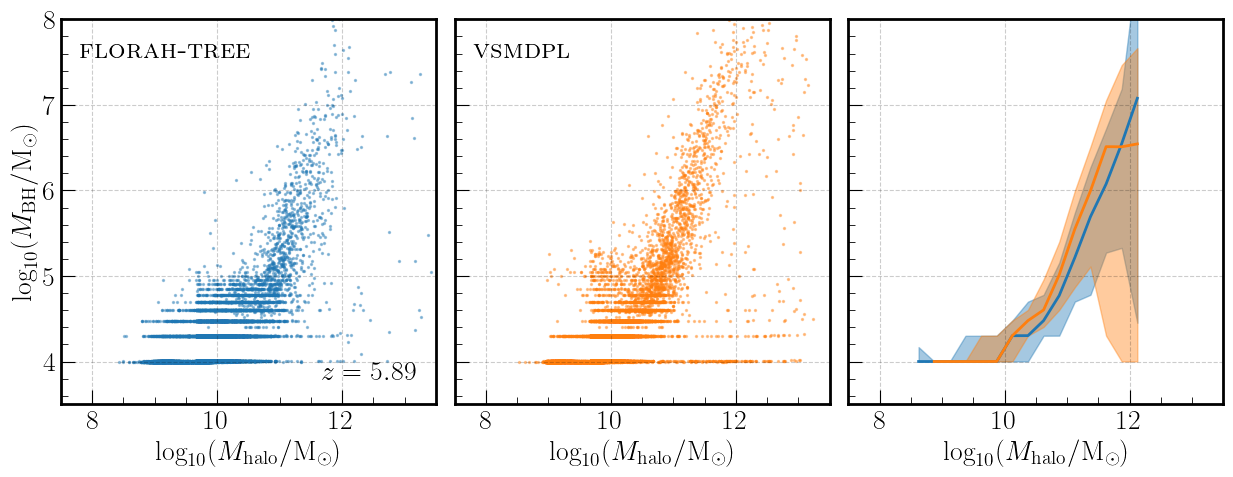

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

sim_label = r'\textsc{vsmdpl}'
gen_label = r'\textsc{florah-tree}'
gen_color = 'C0'
sim_color = 'C1'
xlim = (7.5, 13.5)
ylim = (3.5, 8)
# xlim = (10.5, 12.0)

# plot only the generated galaxies
axes[0].scatter(
    gen_log_mhalo, gen_log_mbh, s=2, alpha=0.4, c='C0')

# plot only the simulated galaxies
axes[1].scatter(
    sim_log_mhalo, sim_log_mbh, s=2, alpha=0.4, c='C1')

# plot both but only the median and 16-84 percentile
axes[2].plot(
    mhalo_bins_ce, gen_log_mbh_q[:, 0], color=gen_color, lw=2)
axes[2].fill_between(
    mhalo_bins_ce, gen_log_mbh_q[:, 1], gen_log_mbh_q[:, 2],
    alpha=0.4, color=gen_color)
axes[2].plot(
    mhalo_bins_ce, sim_log_mbh_q[:, 0], color=sim_color, lw=2)
axes[2].fill_between(
    mhalo_bins_ce, sim_log_mbh_q[:, 1], sim_log_mbh_q[:, 2],
    alpha=0.4, color=sim_color)

axes[0].set_ylabel(r'$\log_{10}(M_{\rm BH}/ \rm M_{\odot})$')
for ax in axes:
    ax.set_xlabel(r'$\log_{10}(M_{\rm halo}/ \rm M_{\odot})$')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)

# annotate the panels
axes[0].text(
    0.05, 0.95, gen_label,
    transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(
    0.05, 0.95, sim_label,
    transform=axes[1].transAxes, ha='left', va='top')

# redshift at the lower right
axes[0].text(
    0.95, 0.05, r'$z={{{}}}$'.format(z),
    transform=axes[0].transAxes, ha='right', va='bottom')

fig.subplots_adjust(wspace=0.05)
plt.show()